In [1]:
import numpy as np
import pandas as pd
#pd.set_option('precision', 3)
from itertools import compress
import copy, sys, os, warnings
import matplotlib.pyplot as plt
from pyirr import intraclass_correlation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold, permutation_test_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix, make_scorer
from scipy.stats import spearmanr, mannwhitneyu
from compare_auc_delong import delong_roc_test
import shap

oldPath = os.path.join(os.path.expanduser('~'), 'Documents/GitHub/icrpythonradiomics/machineLearning')
if os.path.exists(oldPath) and oldPath in sys.path:
    sys.path.remove(oldPath)
sys.path.append(os.path.join(os.path.expanduser('~'), 'Documents/git/git_icrpythonradiomics/machineLearning'))
from featureSelection import featureSelection_correlation as featSelCorr

dataFolder = os.path.join(os.path.expanduser('~'), 'Dropbox (ICR)/CLINMAG/Radiomics/ECE_Prostate_Semantic')

# validation parameters
n_splits = 10
n_repeats = 10

permutationTest = False
n_permutations = 100

crossValidate = True

In [2]:
def confusion_matrix_thresholds(yTrue, yScore, thresholds):
    tnArr, fpArr, fnArr, tpArr = [], [], [], []
    nSamples = len(yTrue)
    for thresh in thresholds:
        tn, fp, fn, tp = confusion_matrix(yTrue, yScore>thresh).ravel()
        tnArr.append(tn)
        fpArr.append(fp)
        fnArr.append(fn)
        tpArr.append(tp)
    return np.array(tnArr), np.array(fpArr), np.array(fnArr), np.array(tpArr)

In [3]:
def calculate_fnr(y_true, y_pred, pt=0):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    return fn/(fn + tp)


def calculate_fpr(y_true, y_pred, pt=0):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    return fp/(fp + tn)


def calculate_net_benefit_score(y_true, y_pred, pt=0):
    _, fp, _, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    net_benefit = (tp - fp * (pt / (1 - pt))) / len(y_true)
    return net_benefit


def unpack_scorers(cvr):

    thresh_FNR, thresh_FPR, thresh_DCA, value_DCA, value_FNR, value_FPR = [], [], [], [], [], []
    
    for key, value in cvr.items():
        if 'test_FNR' in key:
            thresh_FNR.append(float(key.replace('test_FNR_','')))
            value_FNR.append(np.mean(value))
        if 'test_FPR' in key:
            thresh_FPR.append(float(key.replace('test_FPR_','')))
            value_FPR.append(np.mean(value))
        if 'test_DCA' in key:
            thresh_DCA.append(float(key.replace('test_DCA_','')))
            value_DCA.append(np.mean(value))

    idxFNR = np.argsort(thresh_FNR)
    idxFPR = np.argsort(thresh_FPR)
    idxDCA = np.argsort(thresh_DCA)

    FNR = {'thresholds': [thresh_FNR[idx] for idx in idxFNR],
           'values': [value_FNR[idx] for idx in idxFNR]}
    
    FPR = {'thresholds': [thresh_FPR[idx] for idx in idxFPR],
           'values': [value_FPR[idx] for idx in idxFPR]}

    DCA = {'thresholds': [thresh_DCA[idx] for idx in idxDCA],
           'values': [value_DCA[idx] for idx in idxDCA]}
    
    return FNR, FPR, DCA

# Make dictionary of scorers, each of which will compute one point on the FNR and FPR curves.
# The dictionary key is used to keep track of the threshold value that was used.
scorers = {}

# Don't use 0 and 1 as endpoints as this causes numerical underflow.
ptArr = np.round(np.linspace(0, 1, 101),2)
ptArr[0] = np.round(0.0001,4)
ptArr[-1] = np.round(0.9999,4)

for pt in ptArr:
    scorers['FNR_' + str(pt)] = make_scorer(calculate_fnr, pt = pt, needs_proba=True)
    scorers['FPR_' + str(pt)] = make_scorer(calculate_fpr, pt = pt, needs_proba=True)
    scorers['DCA_' + str(pt)] = make_scorer(calculate_net_benefit_score, pt = pt, needs_proba=True)

# standard scorers    
scorers['roc_auc'] = 'roc_auc'
scorers['accuracy'] = 'accuracy'
scorers['f1'] = 'f1'

## Load two reader semantic data (for computing ICCs) 

In [4]:
twoReaderFile = os.path.join(dataFolder, 'ECE_Semantic_Data', 'GG_MG.xlsx')

# read spreadsheet
df = pd.read_excel(twoReaderFile, sheet_name='GG_MG', engine='openpyxl')

# remove features, as with the discovery/test data
df.drop(['IndexLesion_GG', 'IndexLesionMG', 'GlobalStageGG', 'GlobalStageMG'], axis=1, inplace=True)

# remove rows with missing data - need to check that this leaves the same patients for dfGG as in the discovery data set
df.dropna(inplace=True)

# split to each reader
dfGG = df.filter(regex = 'GG|PID', axis = 1)
dfMG = df.filter(regex='MG|PID', axis=1)

# match column names by removing subscripts
dfGG = dfGG.rename(columns=lambda x: x.replace('_GG','').replace('GG',''))
dfMG = dfMG.rename(columns=lambda x: x.replace('_MG','').replace('MG',''))

# change some column names to match the discovery/test data sets
renameDict = {'LocIndexL':'AnatDev01',
              'LocAnat':'AnatDev02',
              'Division':'AnatDev03',
              'DivisionLat':'AnatDev04',
              'LesionSize':'MajorLengthIndex',
              'SmoothCapsularBulgin':'SmoothCapsularBulging',
              'UnsharpMargins':'UnsharpMargin',
              'irregularContour':'IrregularContour',
              'BlackEstrition':'BlackEstritionPeripFat',
              'measurableECE':'MeasurableECE',
              'retroprostaticAngleObl':'RetroprostaticAngleOblit'}
dfGG.rename(renameDict, axis=1, inplace=True)
dfMG.rename(renameDict, axis=1, inplace=True)

# highsignalT1FS is missing from this spreadsheet, so fill in with default value.
# Fortunately, this feature is not selected in the final model, but we need it there for compatibility.
dfGG.loc[:, 'highsignalT1FS'] = 0
dfMG.loc[:, 'highsignalT1FS'] = 0

iccDict = {}
for col in dfGG.drop(['PID', 'highsignalT1FS'], axis=1):
    data = np.stack((dfGG[col], dfMG[col]), axis=1)
    iccDict['semantic_' + col] = intraclass_correlation(data, "twoway", "agreement").value

## Read and prepare radiomics data (discovery and test) 

In [5]:
radiomicsFile = os.path.join(dataFolder, 'ECE_Semantic_Data', 'radiomicFeatures__202209271126.csv')

dfRad = pd.read_csv(radiomicsFile)
dfRad.drop(list(dfRad.filter(regex = 'source')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'diagnostics')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'histogram')), axis = 1, inplace = True)

# remove feature sets we don't want to use and remove string from the one that is left
dfRad.drop(list(dfRad.filter(regex = 'noNormalize|maskNormalize')), axis = 1, inplace = True)
dfRad = dfRad.rename(columns=lambda x: x.replace('normalized_',''))

# To match the semantic data file
dfRad['StudyPatientName'] = dfRad['StudyPatientName'].str.replace('_',' ')

# sensible prefix 
dfRad = dfRad.rename(columns=lambda x: x.replace('original','radiomics'))

# split off the repro rows
dfRep1 = dfRad.loc[dfRad.StudyPatientName.str.contains('rep'),:].copy()
dfRep1['StudyPatientName'] = dfRep1['StudyPatientName'].str.replace(' repro','')
dfRep1.sort_values('StudyPatientName', axis=0, inplace=True)
dfRep1.reset_index(inplace=True, drop=True)

# remove repro from main data frame
dfRad = dfRad.loc[~dfRad.StudyPatientName.str.contains('rep'),:]
dfRad.reset_index(inplace=True, drop=True)

# main data rows for same patients as repro
dfRep0 = dfRad.loc[dfRad['StudyPatientName'].isin(dfRep1['StudyPatientName'])].copy()
dfRep0.sort_values('StudyPatientName', axis=0, inplace=True)
dfRep0.reset_index(inplace=True, drop=True)

for col in dfRep1.drop('StudyPatientName', axis=1):
    data = np.stack((dfRep0[col], dfRep1[col]), axis=1)
    iccDict[col] = intraclass_correlation(data, "twoway", "agreement").value

# dfRad = dfRad.filter(regex='shape|firstorder|StudyPatientName')

## Read and prepare semantic data (discovery and test)

In [6]:
discoveryFile = os.path.join(dataFolder, 'ECE_Semantic_Data', 'discovery.csv')
externalTestFile = os.path.join(dataFolder, 'ECE_Semantic_Data', 'external.csv')
    
# load data
dfTrain = pd.read_csv(discoveryFile)
dfTest  = pd.read_csv(externalTestFile)

# drop features we are not going to use for classification
dfTrain.drop(['Gleason biopsy','TumorGradeMRI'], inplace=True, axis=1)
dfTest.drop(['Gleason biopsy','TumorGradeMRI'], inplace=True, axis=1)

# change this feature to have a more descriptive name
dfTrain.insert(1, 'Gleason>(3+4)', dfTrain['GleasonBinary'])
dfTest.insert(1, 'Gleason>(3+4)', dfTest['GleasonBinary'])
dfTrain.drop('GleasonBinary', axis=1, inplace=True)
dfTest.drop('GleasonBinary', axis=1, inplace=True)

# make these features binary 0/1
toBinary = ['SmoothCapsularBulging' ,'CapsularDisruption', 'UnsharpMargin', 'IrregularContour', 'BlackEstritionPeripFat', 'MeasurableECE', 'RetroprostaticAngleOblit', 'highsignalT1FS']
for tb in toBinary:
    dfTrain[tb]  = dfTrain[tb].map(dict(YES=1, NO=0))
    dfTest[tb] = dfTest[tb].map(dict(YES=1, NO=0))

# simplify PIRADS (as ECE rate for 3 and 4 is around 20% and for 5 is around 75%)
dfTrain.insert(4, 'PIRADS>4', (dfTrain['IndLesPIRADS_V2'] > 4).astype(int))
dfTrain.drop('IndLesPIRADS_V2', axis=1, inplace=True)
dfTest.insert(4, 'PIRADS>4', (dfTest['IndLesPIRADS_V2'] > 4).astype(int))
dfTest.drop('IndLesPIRADS_V2', axis=1, inplace=True)

# log transform some features to get rid of long tail
dfTrain.ProstateVolume = np.log(dfTrain.ProstateVolume)
dfTest.ProstateVolume = np.log(dfTest.ProstateVolume)
dfTrain.PSA = np.log(dfTrain.PSA)
dfTest.PSA = np.log(dfTest.PSA)

# is missing in test and training, so replace both with median from the training data
psaTrainMedian = np.nanmedian(np.array(dfTrain.PSA))
dfTrain.PSA.fillna(psaTrainMedian, inplace=True)
dfTest.PSA.fillna(psaTrainMedian, inplace=True)

# this feature is not selected in the semantic model, so this has no effect
# fill in with the most common value
dfTest.highsignalT1FS.fillna(0, inplace=True)

# add string to names for easy manipulation of groups
clinicalFeatures = ['Gleason>(3+4)', 'ProstateVolume', 'PSA', 'PIRADS>4']
semanticFeatures = list(set(dfTrain.columns) - set(clinicalFeatures) - set(['PID', 'ECE_Pathology']))
dfTrain = dfTrain.rename(columns=lambda x: 'clinical_' + x if x in clinicalFeatures else x)
dfTest = dfTest.rename(columns=lambda x: 'clinical_' + x if x in clinicalFeatures else x)
dfTrain = dfTrain.rename(columns=lambda x: 'semantic_' + x if x in semanticFeatures else x)
dfTest = dfTest.rename(columns=lambda x: 'semantic_' + x if x in semanticFeatures else x)

# merge radiomics 
dfTrain = dfTrain.merge(dfRad, left_on='PID', right_on='StudyPatientName')
dfTest = dfTest.merge(dfRad, left_on='PID', right_on='StudyPatientName')
dfTrain = dfTrain.drop(['PID', 'StudyPatientName'], axis=1)
dfTest = dfTest.drop(['PID', 'StudyPatientName'], axis=1)


## Main model fitting function 

In [7]:
# some functions to help get smooth ROC and DCA curves for the test data

def jitterColumns(df, scale):
    for col in df:
        df[col] = df[col] + np.random.normal(loc=0, scale=scale*np.std(df[col]), size=df[col].shape)
    return df

def replicateDf(df, N):
    dfOut = df.copy()
    for n in range(N-1):
        dfOut = pd.concat([dfOut, df], axis=0)
    return dfOut

In [8]:
def fitModel(dfTrain, dfTest, pipeline, coefDisplayFunction=None, keepRegex=None, dropList = None, permutationTest=False, jitterTestData=False, crossValidate=True):

    # reproducible execution
    seed = 42
    np.random.seed(seed)

    # get training and test data
    XTrain = dfTrain.drop('ECE_Pathology', axis=1)
    XTest = dfTest.drop('ECE_Pathology', axis=1)
    yTrain = dfTrain.ECE_Pathology
    yTest = dfTest.ECE_Pathology
    
    # keep features as indicated
    if keepRegex is not None:
        XTrain = XTrain.filter(regex = keepRegex)
        XTest = XTest.filter(regex = keepRegex)
        
    # discard features listed
    if dropList is not None:
        XTrain.drop(dropList, axis=1, inplace=True)
        XTest.drop(dropList, axis=1, inplace=True)
     
    print(XTrain.columns)
    
    # make sure correlationSelector will not remove any clinical or semantic features
    if pipeline.steps[0][0] == 'correlationSelector':
        pipeline.steps[0][1].namedColumnsKeep = [x for x in XTrain.columns if 'clinical' in x or 'semantic' in x]
        
    # drop low variance radiomics features (in practice this only includes radiomics_glcm_Idmn)
    CoV = pd.DataFrame(XTrain.apply(lambda x: np.std(x)/(0.0001 + np.mean(x)), axis=0))
    lowVarianceFeatures = CoV.loc[np.abs(CoV.loc[:,0])<0.01,:].index.values.tolist()
    lowVarianceFeatures = [x for x in lowVarianceFeatures if 'clinical' not in x and 'semantic' not in x]
    XTrain.drop(lowVarianceFeatures, axis = 1, inplace = True)
    XTest.drop(lowVarianceFeatures, axis = 1, inplace = True)

    # fit to all data
    pipeline.fit(XTrain, yTrain)

    if crossValidate:
        # cross-validate
        outer_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
        cv_result = cross_validate(pipeline, 
                                   XTrain, 
                                   yTrain, 
                                   cv=outer_cv, 
                                   scoring=scorers,
                                   return_estimator=True, 
                                   verbose=0, 
                                   n_jobs=-1)

        # print CV scores
        AUC_CV = np.mean(cv_result['test_roc_auc'])
        Accuracy_CV = np.mean(cv_result['test_accuracy'])
        F1_CV = np.mean(cv_result['test_f1'])
        print('AUCROC   (CV) = ' + str(AUC_CV.round(3)) + ' \u00B1 ' + str(np.round(np.std(cv_result['test_roc_auc']),3)))
        print('Accuracy (CV) = ' + str(Accuracy_CV.round(3)) + ' \u00B1 ' + str(np.round(np.std(cv_result['test_accuracy']),3)))
        print('F1       (CV) = ' + str(F1_CV.round(3)) + ' \u00B1 ' + str(np.round(np.std(cv_result['test_f1']),3)))

        FNR_CV, FPR_CV, DCA_CV = unpack_scorers(cv_result)
    else:
        cv_result, AUC_CV, Accuracy_CV, F1_CV, FNR_CV, FPR_CV, DCA_CV = None, None, None, None, None, None, None
        

    # permutation testing
    if permutationTest:
        outer_cv.n_repeats = 1

        warnings.simplefilter("ignore")
        os.environ["PYTHONWARNINGS"] = "ignore"
        #
        scoreDirect, perm_scores, pValueDirect = permutation_test_score(pipeline, 
                                                                        XTrain, 
                                                                        yTrain, 
                                                                        scoring="roc_auc",
                                                                        cv=outer_cv, 
                                                                        n_permutations=n_permutations,
                                                                        verbose=0, n_jobs=-1)
        #
        warnings.simplefilter('default')
        os.environ["PYTHONWARNINGS"] = 'default'

        # pValueDirect is computed using scoreDirect and assumes only one outer CV run
        # We have used repeated outer CV, so the following code correctly computes the p-value of our repeated CV performance estimate
        # Actually, it doesn't seem to make much difference, so am relaxed about that.

        p_values = []
        scores_roc_auc = np.mean(np.reshape(cv_result['test_roc_auc'], (n_repeats, -1)), axis=1)
        for score in scores_roc_auc:
            p_values.append((np.count_nonzero(perm_scores >= score) + 1) / (n_permutations + 1))
        pValue_CV = np.mean(p_values)
        print('p-value       = ' + str(pValue_CV.round(4)))
    else:
        pValue_CV = None
    
    # replicate and add jitter to test data to give smoother roc and DCA curves
    if jitterTestData:
        XTest = replicateDf(XTest, 20)
        yTest = replicateDf(yTest, 20)
        XTest = jitterColumns(XTest, 0.1)

    # get scores and predicted class info
    test_score = pipeline.predict_proba(XTest)[:, 1]
    test_class = pipeline.predict(XTest)

    # test scores from main model
    testAUROC = roc_auc_score(yTest, test_score)
    testAccuracy = accuracy_score(yTest, test_class)
    testF1 = f1_score(yTest, test_class)

    pValueTest = mannwhitneyu(test_score[yTest==0], test_score[yTest==1], alternative='two-sided').pvalue

    # print the test performance metrics
    print('\nAUCROC   (test) = ' + str(np.round(testAUROC,3)))
    print('Accuracy (test) = ' + str(np.round(testAccuracy,3)))
    print('F1       (test) = ' + str(np.round(testF1,3)))
    print('p-value  (test) = ' + str(np.round(pValueTest, 6)))

    if coefDisplayFunction is not None:
        dfCoefResults = coefDisplayFunction(pipeline, XTrain.columns, cv_result)

    out = {'test_AUC':testAUROC,
           'test_score':test_score,
           'test_class':test_class,
           'test_accuracy':testAccuracy,
           'test_f1':testF1,
           'test_pValue':pValueTest,
           'AUC_CV':AUC_CV,
           'Accuracy_CV':Accuracy_CV,
           'F1_CV':F1_CV,
           'pValue_CV':pValue_CV,
           'FNR_CV':FNR_CV,
           'FPR_CV':FPR_CV,
           'DCA_CV':DCA_CV,
           'XTrain':XTrain.copy(),
           'XTest':XTest.copy(),
           'yTrain':yTrain.copy(),
           'yTest':yTest.copy(),
           'pipeline':pipeline,
           'cv_result':cv_result
          }
    
    return out



## Some logistic regression pipelines 

In [9]:
# basic logistic regression, no regularisation
pipelineLRsimple = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('lr', LogisticRegression(penalty='none'))])

# logistic regression with lasso
pipelineLRlasso = Pipeline(steps=[('scaler', StandardScaler()), 
                                  ('lr', LogisticRegressionCV(Cs=20, 
                                                              cv=10, 
                                                              solver="liblinear",
                                                              max_iter=10000, 
                                                              penalty='l1',
                                                              random_state=42))])

# logistic regression with ridge
pipelineLRridge = Pipeline(steps=[('scaler', StandardScaler()), 
                                  ('lr', LogisticRegressionCV(Cs=20, 
                                                              cv=10, 
                                                              solver="liblinear",
                                                              max_iter=10000, 
                                                              penalty='l2',
                                                              random_state=42))])


# logistic regression with lasso, preceded by correlation feature reduction
# fitModel function will modify pipeline to make sure the clinical and semantic features are not affected by
# correlation feature reduction
pipelineCfrLRlasso = Pipeline([('correlationSelector', featSelCorr(threshold=0.9,
                                                                   exact=False,
                                                                   featureGroupHierarchy=['shape_MeshVolume',
                                                                                          'shape',
                                                                                          'firstorder'])),
                               ('scaler', StandardScaler()),
                               ('lr', GridSearchCV(estimator=LogisticRegression(solver="liblinear", 
                                                                                max_iter=10000, 
                                                                                penalty='l1'), 
                                                   param_grid={'C':np.logspace(np.log10(0.05), np.log10(50), 20)}, 
                                                   cv=StratifiedKFold(n_splits=10), 
                                                   refit=True, 
                                                   verbose=0, 
                                                   scoring='neg_log_loss', 
                                                   n_jobs=1))])

# logistic regression with ridge, preceded by correlation feature reduction
# fitModel function will modify pipeline to make sure the clinical and semantic features are not affected by
# correlation feature reduction
pipelineCfrLRridge = Pipeline([('correlationSelector', featSelCorr(threshold=0.9,
                                                                   exact=False,
                                                                   featureGroupHierarchy=['shape_MeshVolume',
                                                                                          'shape',
                                                                                          'firstorder'])),
                               ('scaler', StandardScaler()),
                               ('lr', GridSearchCV(estimator=LogisticRegression(solver="liblinear", 
                                                                                max_iter=10000, 
                                                                                penalty='l2'), 
                                                   param_grid={'C':np.logspace(np.log10(0.05), np.log10(50), 20)}, 
                                                   cv=StratifiedKFold(n_splits=10), 
                                                   refit=True, 
                                                   verbose=0, 
                                                   scoring='neg_log_loss', 
                                                   n_jobs=1))])

# logistic regression with lasso using GridSearchCV
pipelineLRlasso2 = Pipeline([('scaler', StandardScaler()),
                                ('lr', GridSearchCV(estimator=LogisticRegression(solver="liblinear", 
                                                                                 max_iter=10000, 
                                                                                 penalty='l1'), 
                                                    param_grid={'C':np.logspace(np.log10(1e-4), np.log10(1e4), 20)}, 
                                                    cv=StratifiedKFold(n_splits=10), 
                                                    refit=True, 
                                                    verbose=0, 
                                                    scoring='neg_log_loss', 
                                                    n_jobs=1))])


## Functions to display non-zero logistic regression coeffients for the pipelines

In [10]:
def coefDispFunLRsimple(pipeline, featureNames, dummy):
    dfCoefResults = pd.DataFrame({'Feature':[x.replace('clinical_','') for x in featureNames], 
                                  'Coeff':np.squeeze(pipeline._final_estimator.coef_)})
    dfCoefResults.sort_values(by='Coeff', key=abs, inplace=True, ascending=False)
    if '3.6.' in sys.version:
        display(dfCoefResults.style.hide_index())
    else:
        display(dfCoefResults)
#     print(dfCoefResults.to_string(index=False))

def coefDispFunLRlasso(pipeline, featureNames, cv_result):

    # get frequency that features are non-zero across the repeated cv splits
    if cv_result is not None:
        coef_cv = np.zeros((len(cv_result['estimator']), len(featureNames)))
        for n, res in enumerate(cv_result['estimator']):
            coef_cv[n, :] = res._final_estimator.coef_
        coef_freq = np.sum(coef_cv != 0, axis=0) / (n_repeats * n_splits)
    else:
        coef_freq = [0]*len(featureNames)
        
    # put icc values in array for including in DataFrame
    iccList = []
    for feat in featureNames:
        if feat in iccDict:
            iccList.append(iccDict[feat])
        else:
            iccList.append('-')

    # simplify feature names
    featureNames = [x.replace('clinical_','') for x in featureNames]
    featureNames = [x.replace('semantic_','') for x in featureNames]
    featureNames = [x.replace('radiomics_','') for x in featureNames]
            
    # display sorted coefficients and selection frequency
    coeffs = np.squeeze(pipeline._final_estimator.coef_)
    dfCoefResults = pd.DataFrame({'Feature': featureNames, 'Coeff': coeffs, 'Freq': coef_freq, 'ICC':iccList})
    dfCoefResults.sort_values(by=['Coeff', 'Freq'], key=abs, inplace=True, ascending=False)
    if '3.6.' in sys.version:
        display(dfCoefResults.loc[dfCoefResults.Coeff != 0, :].style.hide_index())
    else:
        display(dfCoefResults.loc[dfCoefResults.Coeff != 0, :])
#     print(dfCoefResults.loc[dfCoefResults.Coeff != 0, :].to_string(index=False))

def coefDispFunCfrLRlasso(pipeline, featureNames, cv_result):
    
    # get frequency that features are non-zero across the repeated cv splits
    if cv_result is not None:
        coef_cv = np.zeros((len(cv_result['estimator']), len(featureNames)))
        fs_mask = np.zeros((len(cv_result['estimator']), len(featureNames)))
        for n, res in enumerate(cv_result['estimator']):
            fs_mask[n, :] = res.steps[0][1].mask_
            coef_cv[n, res.steps[0][1].mask_] = res._final_estimator.best_estimator_.coef_
        coef_freq = np.sum(coef_cv != 0, axis=0) / (n_repeats * n_splits)
    else:
        coef_freq = [0]*len(featureNames)

    # put icc values in array for including in DataFrame
    iccList = []
    for feat in featureNames:
        if feat in iccDict:
            iccList.append(iccDict[feat])
        else:
            iccList.append('-')

    # simplify feature names
    featureNames = [x.replace('clinical_','') for x in featureNames]
    featureNames = [x.replace('semantic_','') for x in featureNames]
    featureNames = [x.replace('radiomics_','') for x in featureNames]
            
    # display sorted coefficients and selection frequency
    coeffs = np.zeros(len(featureNames))
    coeffs[pipeline.steps[0][1].mask_] = np.squeeze(pipeline._final_estimator.best_estimator_.coef_)

    dfCoefResults = pd.DataFrame({'Feature': featureNames, 'Coeff': coeffs, 'Freq': coef_freq, 'ICC':iccList})
    dfCoefResults.sort_values(by=['Coeff', 'Freq'], key=abs, inplace=True, ascending=False)
    if '3.6.' in sys.version:
        display(dfCoefResults.loc[dfCoefResults.Coeff != 0, :].style.hide_index())
    else:
        display(dfCoefResults.loc[dfCoefResults.Coeff != 0, :])
#     print(dfCoefResults.loc[dfCoefResults.Coeff != 0, :].to_string(index=False))

def coefDispFunLRlasso2(pipeline, featureNames, cv_result):

    # get frequency that features are non-zero across the repeated cv splits
    if cv_result is not None:
        coef_cv = np.zeros((len(cv_result['estimator']), len(featureNames)))
        for n, res in enumerate(cv_result['estimator']):
            coef_cv[n, :] = res.steps[1][1].best_estimator_.coef_
        coef_freq = np.sum(coef_cv != 0, axis=0) / (n_repeats * n_splits)
    else:
        coef_freq = [0]*len(featureNames)
        
    # put icc values in array for including in DataFrame
    iccList = []
    for feat in featureNames:
        if feat in iccDict:
            iccList.append(iccDict[feat])
        else:
            iccList.append('-')

    # simplify feature names
    featureNames = [x.replace('clinical_','') for x in featureNames]
    featureNames = [x.replace('semantic_','') for x in featureNames]
    featureNames = [x.replace('radiomics_','') for x in featureNames]
            
    # display sorted coefficients and selection frequency
    coeffs = np.squeeze(pipeline._final_estimator.best_estimator_.coef_)
    dfCoefResults = pd.DataFrame({'Feature': featureNames, 'Coeff': coeffs, 'Freq': coef_freq, 'ICC':iccList})
    dfCoefResults.sort_values(by=['Coeff', 'Freq'], key=abs, inplace=True, ascending=False)
    if '3.6.' in sys.version:
        display(dfCoefResults.loc[dfCoefResults.Coeff != 0, :].style.hide_index())
    else:
        display(dfCoefResults.loc[dfCoefResults.Coeff != 0, :])
#     print(dfCoefResults.loc[dfCoefResults.Coeff != 0, :].to_string(index=False))

## Functions for SHAP beeswarm plots for the pipelines

In [11]:
def showShapLR(r, file=None):
    standardiser = r['pipeline'].steps[0][1]

    X = pd.DataFrame(columns=r['XTest'].columns, data=standardiser.transform(r['XTest'].copy()))
    X = X.rename(columns=lambda x: x.replace('clinical_',''))
    X = X.rename(columns=lambda x: x.replace('semantic_',''))
    X = X.rename(columns=lambda x: x.replace('radiomics_',''))
    
    
    explainer = shap.explainers.Linear(r['pipeline']._final_estimator, X)
    shap_values = explainer(X)
    max_display = 1 + np.sum(r['pipeline']._final_estimator.coef_ != 0)
    shap.plots.beeswarm(shap_values, max_display=max_display, show=False)

    if file is not None:
        plt.savefig(file, bbox_inches='tight')
    plt.show()

# use this version when LR tuning done uing GridSearch
def showShapLR2(r, file=None):
    standardiser = r['pipeline'].steps[0][1]

    # get final estimator and refit to the non-zero coefficients
#     estimator = r['pipeline']._final_estimator.best_estimator_.copy()
#     coef = 
#     estimator.fit(r['XTrain'], r['yTrain'])

    X = pd.DataFrame(columns=r['XTest'].columns, data=standardiser.transform(r['XTest'].copy()))
    X = X.rename(columns=lambda x: x.replace('clinical_',''))
    X = X.rename(columns=lambda x: x.replace('semantic_',''))
    X = X.rename(columns=lambda x: x.replace('radiomics_',''))
    
    
    explainer = shap.explainers.Linear(r['pipeline']._final_estimator.best_estimator_, X)
    shap_values = explainer(X)
    max_display = 1 + np.sum(r['pipeline']._final_estimator.best_estimator_.coef_ != 0)
    shap.plots.beeswarm(shap_values, max_display=max_display, show=False)

    if file is not None:
        plt.savefig(file, bbox_inches='tight')
    plt.show()

def showShapLRcfr(r, file=None):

    mask = r['pipeline'].steps[0][1].mask_
    standardiser = r['pipeline'].steps[1][1]

    X = r['XTest'].loc[:,mask]
    X = standardiser.transform(X)
    X = pd.DataFrame(columns=r['XTest'].columns[mask], data=X)
    X = X.rename(columns=lambda x: x.replace('clinical_',''))
    X = X.rename(columns=lambda x: x.replace('semantic_',''))
    X = X.rename(columns=lambda x: x.replace('radiomics_',''))
    
    model = r['pipeline']._final_estimator.best_estimator_
    explainer = shap.explainers.Linear(model, X)
    shap_values = explainer(X)
    max_display = 1 + np.sum(model.coef_ != 0)
    shap.plots.beeswarm(shap_values, max_display=max_display, show=False)

    if file is not None:
        plt.savefig(file, bbox_inches='tight')
    plt.show()


## Fit models to four combinations of input features 

In [ ]:
jitterTestData = False

# for figure naming
if jitterTestData:
    jitterStr = '_testJitter'
else:
    jitterStr = ''
    
models = []

print('Clinical features\n')
rc = fitModel(dfTrain,
              dfTest,
              pipelineLRsimple, 
              coefDisplayFunction=coefDispFunLRsimple, 
              keepRegex='clinical',
              permutationTest=permutationTest,
              jitterTestData=jitterTestData,
              crossValidate=crossValidate)
rc['label'] = 'Clinical'
if not jitterTestData:
    showShapLR(rc) #, file=os.path.join(dataFolder, 'figures', 'shap_clinical.pdf'))
models.append(rc)

print('\n\n\nClinical + Radiomic features\n')
rcr = fitModel(dfTrain,
               dfTest,
               pipelineCfrLRlasso, 
               coefDisplayFunction=coefDispFunCfrLRlasso, 
               keepRegex='clinical|radiomic', 
               permutationTest=permutationTest,
               jitterTestData=jitterTestData,
               crossValidate=crossValidate)
rcr['label'] = 'Clinical + Radiomic'
if not jitterTestData:
    showShapLRcfr(rcr) #, file=os.path.join(dataFolder, 'figures', 'shap_clinical_radiomic.pdf'))
models.append(rcr)

for dropList in [[], ['semantic_MeasurableECE']]:

    label = 'Clinical + Semantic'
    if len(dropList)>0:
        label += ' - MeasECE'
    print('\n\n\n' + label + '\n')
    rcs = fitModel(dfTrain,
                   dfTest,
                   pipelineLRlasso, 
                   coefDisplayFunction=coefDispFunLRlasso, 
                   keepRegex='clinical|semantic', 
                   dropList=dropList,
                   permutationTest=permutationTest,
                   jitterTestData=jitterTestData,
                   crossValidate=crossValidate)
    rcs['label'] = label
    
    if not jitterTestData:
        showShapLR(rcs) #, file=os.path.join(dataFolder, 'figures', 'shap_clinical_semantic.pdf'))
    models.append(rcs.copy())


    label = 'Clinical + Semantic + Radiomic'
    if len(dropList)>0:
        label += ' - MeasECE'
    print('\n\n\n' + label + '\n')
    rcsr = fitModel(dfTrain,
                    dfTest,
                    pipelineCfrLRlasso, 
                    coefDisplayFunction=coefDispFunCfrLRlasso, 
                    keepRegex='clinical|semantic|radiomic', 
                    dropList=dropList,
                    permutationTest=permutationTest,
                    jitterTestData=jitterTestData,
                    crossValidate=crossValidate)
    rcsr['label'] = label
    if not jitterTestData:
        showShapLRcfr(rcsr) #, file=os.path.join(dataFolder, 'figures', 'shap_clinical_semantic_radiomic.pdf'))
    models.append(rcsr.copy())


## Make some plots 

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
ax = ax.ravel()

# discovery data plots

if crossValidate:
        # ROC
    for r in models:
        ax[0].plot(r['FPR_CV']['values'], 
                   [1-x for x in r['FNR_CV']['values']], 
                   label = 'AUC = ' + str(np.round(r['AUC_CV'],3)) + ' ' + r['label'])
    ax[0].set_xlabel('1 - Specificity', fontsize=14)
    ax[0].set_ylabel('Sensitivity', fontsize=14)
    ax[0].set_title('ROC', fontsize=16, fontweight='bold')
    ax[0].legend(fontsize=9)
    ax[0].text(-0.3, 0.5, 'Discovery data, cross-validated', fontsize=16, fontweight='bold', rotation=90, verticalalignment='center')




    # DCA
    TPtrain = np.sum(dfTrain.ECE_Pathology==1)/dfTrain.shape[0]
    FPtrain = np.sum(dfTrain.ECE_Pathology==0)/dfTrain.shape[0]
    for r in models:
        exactScale = TPtrain/r['DCA_CV']['values'][0]
        ax[1].plot(r['DCA_CV']['thresholds'], [x*exactScale for x in r['DCA_CV']['values']], label=r['label'])
    # add treat all and treat none
    pt = np.array(rc['DCA_CV']['thresholds'])
    ax[1].plot(pt, (TPtrain - FPtrain*pt/(1-pt)), label='Treat all', color='k', linestyle='--')
    ax[1].plot([0, 1], [0, 0], label='Treat none', color='k', linestyle=':')

    ax[1].set_title('Net benefit curve', fontsize=16, fontweight='bold')
    ax[1].legend(fontsize=9)
    ax[1].set_xlabel('Threshold', fontsize=14)
    ax[1].set_ylabel('Net benefit curve', fontsize=14)
    ax[1].set_ylim([-0.2, 0.4])
    ax[1].set_xlim([0, 1])
                        
# test data plots

# ROC
for r in models:
    fpr, tpr, _ = roc_curve(r['yTest'], r['test_score'])
    ax[2].plot(fpr, tpr, label='AUC = ' + str(np.round(r['test_AUC'],3)) + ' ' + r['label'])
ax[2].set_xlabel('1 - Specificity', fontsize=14)
ax[2].set_ylabel('Sensitivity', fontsize=14)
ax[2].text(-0.3, 0.5, 'Test data', fontsize=16, fontweight='bold', rotation=90, verticalalignment='center')

# default model using semantic_MeasurableECE
tn, fp, fn, tp = confusion_matrix(dfTest['ECE_Pathology'], dfTest['semantic_MeasurableECE']).ravel()
ax[2].plot(fp/(fp+tn), 1-fn/(fn+tp), marker='o', label='MeasurableECE')
ax[2].legend(fontsize=9)


# FNR, FPR and DCA
for r in models:
    thresh = np.unique(r['test_score'])
    thresh = np.append(thresh, 1e-6)
    thresh = np.append(thresh, 1-1e-6)
    thresh = np.sort(thresh)
    tn, fp, fn, tp = confusion_matrix_thresholds(r['yTest'], r['test_score'], thresh)
    ax[3].plot(thresh, (tp - fp * (thresh / (1 - thresh))) / len(r['yTest']), label=r['label'])
ax[3].plot(thresh, (tp[0] - fp[0] * (thresh / (1 - thresh))) / len(r['yTest']), label='Treat all', color='k', linestyle='--')
ax[3].plot([0, 1], [0, 0], label='Treat none', color='k', linestyle=':')

ax[3].legend(fontsize=9)
ax[3].set_xlabel('Threshold', fontsize=14)
ax[3].set_ylabel('Net benefit', fontsize=14)
ax[3].set_ylim([-0.2, 0.4])
ax[3].set_xlim([0, 1.0])


# figFile = os.path.join(dataFolder, 'figures', 'ROC_NetBenefit' + jitterStr + '.pdf')
# plt.savefig(figFile)
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
ax = ax.ravel()

# discovery data plots

models = [rc, rcs, rcr, rcsr]

if crossValidate:
    # FNR
    for r in models:
        ax[0].plot(r['FNR_CV']['thresholds'], r['FNR_CV']['values'], label=r['label'])
    ax[0].set_title('False negative rate', fontsize=16, fontweight='bold')
    ax[0].legend(fontsize=11)
    ax[0].set_xlabel('Threshold', fontsize=14)
    ax[0].set_ylabel('False negative rate', fontsize=14)
    ax[0].text(-0.3, 0.5, 'Discovery data, cross-validated', fontsize=16, fontweight='bold', rotation=90, verticalalignment='center')

    # FPR
    for r in models:
        ax[1].plot(r['FPR_CV']['thresholds'], r['FPR_CV']['values'], label=r['label'])
    ax[1].set_title('False positive rate', fontsize=16, fontweight='bold')
    ax[1].legend(fontsize=11)
    ax[1].set_xlabel('Threshold', fontsize=14)
    ax[1].set_ylabel('False positive rate', fontsize=14)


# test data plots

# FNR, FPR and DCA
for r in models:
    thresh = np.unique(r['test_score'])
    thresh = np.append(thresh, 1e-6)
    thresh = np.append(thresh, 1-1e-6)
    thresh = np.sort(thresh)
    tn, fp, fn, tp = confusion_matrix_thresholds(r['yTest'], r['test_score'], thresh)
    ax[2].plot(thresh, fn/(fn + tp), label=r['label'])
    ax[3].plot(thresh, fp/(fp + tn), label=r['label'])


ax[2].text(-0.3, 0.5, 'Test data', fontsize=16, fontweight='bold', rotation=90, verticalalignment='center')

for axi in [2, 3]:
    ax[axi].legend(fontsize=9)
    ax[axi].set_xlabel('Threshold', fontsize=14)

ax[2].set_ylabel('False negative rate', fontsize=14)
ax[3].set_ylabel('False positive rate', fontsize=14)

# figFile = os.path.join(dataFolder, 'figures', 'FP_FN' + jitterStr + '.pdf')
# plt.savefig(figFile)
plt.show()

In [ ]:
if not jitterTestData:
    pValue = 10**delong_roc_test(rc['yTest'], rcs['test_score'], rcsr['test_score'])[0,0]
    print('Delong comparing clinical + semantic vs. clinical + semantic + radiomic\np = ' + str(np.round(pValue,3)))

In [ ]:
from deepchecks.tabular import Dataset
target = 'ECE_Pathology'

train_dataset = Dataset(dfTrain.filter(regex = 'clinical|semantic|ECE_Pathology', axis = 1), label=target) #, cat_features=features)
test_dataset = Dataset(dfTest.filter(regex = 'clinical|semantic|ECE_Pathology', axis = 1), label=target) #, cat_features=features)

# train_dataset = Dataset(dfTrain, label=target, cat_features=features)
# test_dataset = Dataset(dfTest, label=target, cat_features=features)

from deepchecks.tabular.checks import TrainTestFeatureDrift

check = TrainTestFeatureDrift()
result = check.run(train_dataset=train_dataset, test_dataset=test_dataset, model=rcs['pipeline'])
result.show()

In [ ]:
from deepchecks.tabular.checks import TrainTestLabelDrift
check = TrainTestLabelDrift()
result = check.run(train_dataset=train_dataset, test_dataset=test_dataset)
result

In [ ]:
confusion_matrix(dfTrain['semantic_MeasurableECE'],dfTrain['clinical_Gleason>(3+4)'])/dfTrain.shape[0]

In [ ]:
confusion_matrix(dfTest['semantic_MeasurableECE'],dfTest['clinical_Gleason>(3+4)'])/dfTest.shape[0]

In [ ]:
dfCheck = pd.concat([dfTest,dfTrain],axis=0)
testTrain = np.ones(dfCheck.shape[0])
testTrain[0:dfTest.shape[0]] = 0
dfCheck['ECE_Pathology'] = testTrain

rCheck = fitModel(dfCheck,
               dfCheck,
               pipelineLRlasso, 
               coefDisplayFunction=coefDispFunLRlasso, 
               keepRegex='clinical|semantic_MeasurableECE|semantic_IrregularContour|semantic_CapsularDisruption|ECE_Pathology', 
               permutationTest=permutationTest,
               jitterTestData=jitterTestData,
               crossValidate=crossValidate)

In [ ]:
dfCheck.filter(regex='clinical|semantic_MeasurableECE|semantic_IrregularContour|semantic_CapsularDisruption|ECE_Pathology')

In [ ]:
rcheck = fitModel(dfTrain,
              dfTest,
              pipelineLRsimple, 
              coefDisplayFunction=coefDispFunLRsimple, 
              keepRegex='semantic_MeasurableECE|clinical_Gleason\>\(3\+4\)', 
              permutationTest=permutationTest,
              jitterTestData=jitterTestData,
              crossValidate=crossValidate)


In [ ]:
dfSim = pd.DataFrame({'clinical_Gleason>(3+4)':[0, 0, 1, 1], 'semantic_MeasurableECE':[0, 1, 0, 1]})
np.reshape(rcheck['pipeline'].predict_proba(dfSim)[:,1],(2,2))

In [ ]:
pd.set_option('display.precision', 3)

dfHere = dfTrain.copy()
dfHere.rename(columns={'semantic_MeasurableECE':'MeasurableECE', 'clinical_Gleason>(3+4)':'Gleason>3+4'}, inplace=True)
ct0 = pd.crosstab(dfHere.loc[dfHere['ECE_Pathology']==0, 'Gleason>3+4'], dfHere.loc[dfHere['ECE_Pathology']==0, 'MeasurableECE'])
ct1 = pd.crosstab(dfHere.loc[dfHere['ECE_Pathology']==1, 'Gleason>3+4'], dfHere.loc[dfHere['ECE_Pathology']==1, 'MeasurableECE'])
ct1/(ct1+ct0)

In [ ]:
dfHere = dfTest.copy()
dfHere.rename(columns={'semantic_MeasurableECE':'MeasurableECE', 'clinical_Gleason>(3+4)':'Gleason>3+4'}, inplace=True)
ct0 = pd.crosstab(dfHere.loc[dfHere['ECE_Pathology']==0, 'Gleason>3+4'], dfHere.loc[dfHere['ECE_Pathology']==0, 'MeasurableECE'])
ct1 = pd.crosstab(dfHere.loc[dfHere['ECE_Pathology']==1, 'Gleason>3+4'], dfHere.loc[dfHere['ECE_Pathology']==1, 'MeasurableECE'])
ct1/(ct1+ct0)

In [ ]:
dfHere = dfTrain.copy()
cm0 = confusion_matrix(dfHere.loc[dfHere['ECE_Pathology']==0,'clinical_Gleason>(3+4)'], dfHere.loc[dfHere['ECE_Pathology']==0,'semantic_MeasurableECE'])
cm1 = confusion_matrix(dfHere.loc[dfHere['ECE_Pathology']==1,'clinical_Gleason>(3+4)'], dfHere.loc[dfHere['ECE_Pathology']==1,'semantic_MeasurableECE'])

cm1/(cm0+cm1)

In [ ]:
confusion_matrix(dfTest['clinical_Gleason>(3+4)'], dfTest['semantic_MeasurableECE'])

In [ ]:
dfHere = dfTest.copy()
cm0 = confusion_matrix(dfHere.loc[dfHere['ECE_Pathology']==0,'clinical_Gleason>(3+4)'], dfHere.loc[dfHere['ECE_Pathology']==0,'semantic_MeasurableECE'])
cm1 = confusion_matrix(dfHere.loc[dfHere['ECE_Pathology']==1,'clinical_Gleason>(3+4)'], dfHere.loc[dfHere['ECE_Pathology']==1,'semantic_MeasurableECE'])

cm1/(cm0+cm1)

In [ ]:
models[0]

In [ ]:
dfTrainHere = dfTrain.copy()
dfTestHere = dfTest.copy()

dfTrainHere['clinical_interaction'] = dfTrainHere['semantic_MeasurableECE']*dfTrainHere['clinical_Gleason>(3+4)']
dfTestHere['clinical_interaction'] = dfTestHere['semantic_MeasurableECE']*dfTestHere['clinical_Gleason>(3+4)']

# dfTrainHere['clinical_MeasurableECE'] = dfTrainHere['semantic_MeasurableECE']
# dfTestHere['clinical_MeasurableECE'] = dfTestHere['semantic_MeasurableECE']

# dfTrainHere.drop(['clinical_ProstateVolume', 'clinical_PIRADS>4', 'clinical_PSA'], axis=1, inplace=True)
# dfTestHere.drop(['clinical_ProstateVolume', 'clinical_PIRADS>4', 'clinical_PSA'], axis=1, inplace=True)

rInt = fitModel(dfTrainHere,
               dfTestHere,
               pipelineLRridge, 
               coefDisplayFunction=coefDispFunLRlasso, 
               keepRegex='clinical|semantic', 
               dropList=[], #'semantic_MeasurableECE', 'clinical_interaction'],
               permutationTest=permutationTest,
               jitterTestData=False,
               crossValidate=crossValidate)
showShapLR(rInt)

Index(['clinical_Gleason>(3+4)', 'semantic_CapsularContactLength',
       'semantic_CapsularDisruption', 'semantic_IrregularContour',
       'semantic_MeasurableECE', 'clinical_interaction'],
      dtype='object')
AUCROC   (CV) = 0.901 ± 0.098
Accuracy (CV) = 0.855 ± 0.084
F1       (CV) = 0.672 ± 0.204

AUCROC   (test) = 0.926
Accuracy (test) = 0.8
F1       (test) = 0.621
p-value  (test) = 0.0


Feature,Coeff
semantic_MeasurableECE,6.113425
interaction,-5.102365
Gleason>(3+4),0.835535
semantic_IrregularContour,0.669353
semantic_CapsularDisruption,0.480008
semantic_CapsularContactLength,0.103987


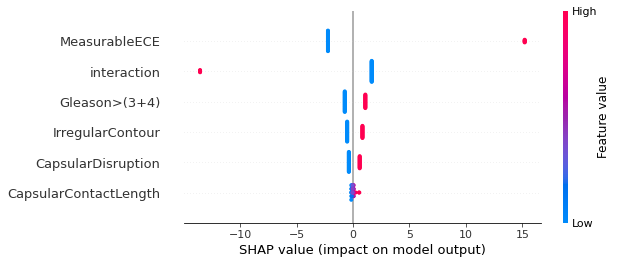

In [14]:
dfTrainHere = dfTrain.copy()
dfTestHere = dfTest.copy()

dfTrainHere['clinical_interaction'] = dfTrainHere['semantic_MeasurableECE']*dfTrainHere['clinical_Gleason>(3+4)']
dfTestHere['clinical_interaction'] = dfTestHere['semantic_MeasurableECE']*dfTestHere['clinical_Gleason>(3+4)']

rInt = fitModel(dfTrainHere,
               dfTestHere,
               pipelineLRsimple, 
               coefDisplayFunction=coefDispFunLRsimple, 
               keepRegex='clinical_interaction|semantic_MeasurableECE|clinical_Gleason\>\(3\+4\)|semantic_CapsularContactLength|semantic_IrregularContour|semantic_CapsularDisruption', 
               dropList=[], #'semantic_MeasurableECE', 'clinical_interaction'],
               permutationTest=permutationTest,
               jitterTestData=False,
               crossValidate=crossValidate)
showShapLR(rInt)

In [ ]:
dfTrainHere = dfTrain.copy()
dfTestHere = dfTest.copy()

r = fitModel(dfTrainHere,
               dfTestHere,
               pipelineLRlasso,
               coefDisplayFunction=coefDispFunLRlasso, 
               keepRegex='clinical|semantic', 
               dropList=['semantic_MeasurableECE'],
               permutationTest=permutationTest,
               jitterTestData=False,
               crossValidate=crossValidate)

In [ ]:
rInt['pipeline']._final_estimator.coef_  #.best_estimator_.fit(rInt['XTrain'], rInt['yTrain'])

In [ ]:
# rInt['pipeline']._final_estimator.Cs_ = rInt['pipeline']._final_estimator.C_
# rInt['pipeline']._final_estimator.Cs = 1
# rInt['pipeline']._final_estimator.coef_ = np.zeros(17)

In [ ]:
est = LogisticRegression(penalty='l1', solver='liblinear', C=rInt['pipeline']._final_estimator.C_[0])
est.fit(rInt['XTrain'],rInt['yTrain'])
est.coef_

In [ ]:
rInt['cv_result']['estimator'][0].steps[1][1].best_estimator_.coef_

In [ ]:
standardiser = r['pipeline'].steps[0][1]

X = pd.DataFrame(columns=r['XTest'].columns, data=standardiser.transform(r['XTest'].copy()))
X = X.rename(columns=lambda x: x.replace('clinical_',''))
X = X.rename(columns=lambda x: x.replace('semantic_',''))
X = X.rename(columns=lambda x: x.replace('radiomics_',''))


explainer = shap.explainers.Linear(r['pipeline']._final_estimator, X)
shap_values = explainer(X)
max_display = 1 + np.sum(r['pipeline']._final_estimator.coef_ != 0)
shap.plots.beeswarm(shap_values, max_display=max_display, show=False)

plt.show()

In [ ]:
showShapLR2(rInt)

In [ ]:
shap_values